In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from mmseg.models.uda.refinement import EncodeDecode
from tqdm import tqdm
import numpy as np
from refinement_module import UNet
from torch.optim.lr_scheduler import OneCycleLR

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def transform_image_path(image_path:str,is_val=False):
    if is_val:
        image_path = image_path.replace("pl_preds","gtFine")
        image_path = image_path.replace("_leftImg8bit.png","_gtFine_labelTrainIds.png")
        return image_path
    else:
        path = "data/cityscapes/sam_colour"
        basename = image_path.split("/")[-1]
        basename = basename.replace(".png", "_pseudoTrainIds.png")
        return os.path.join(path,basename)

In [3]:
transform_to_val = partial(transform_image_path,is_val=True)

In [4]:
class RefinementDataset(Dataset):
    def __init__(self,data_root="data/cityscapes/",mode="train"):
        super().__init__()
        self.pl_paths = glob.glob(os.path.join(data_root,"pl_preds",f"{mode}","**","*.png"),recursive=True)
        self.sam_paths = list(map(transform_image_path,self.pl_paths))
        self.val_paths = list(map(transform_to_val,self.pl_paths))

        self.transform = transforms.Resize((256,256))
            
    def __len__(self):
        return len(self.pl_paths)
    
    def open_image(self, path):
        img = Image.open(path).convert("P")
        img = self.transform(img)
        
        img = np.array(img)
        img.setflags(write=True)
        
        return tensor(img).unsqueeze(0) 
    
    def __getitem__(self, index):
        pl_image = self.open_image(self.pl_paths[index])
        sam_image = self.open_image(self.sam_paths[index])
        gt_image  = self.open_image(self.val_paths[index])
        return pl_image, sam_image, gt_image
            


In [5]:
class GTADataset(Dataset):
    def __init__(self,train_data_root="data/gta/",val_train_root="data/cityscapes/",mode="train"):
        super().__init__()
        self.transform_to_sam = partial(self.transform_to_label,mode="val")
        if mode == "train":
            self.sam_paths = glob.glob(os.path.join(train_data_root,"sam_colour","*_pseudoTrainIds.png"),recursive=True)
            self.labels = list(map(self.transform_to_label,self.sam_paths))

        elif mode == "val":
            self.labels = glob.glob(os.path.join(val_train_root,"gtFine",f"{mode}","**","*_gtFine_labelTrainIds.png"),recursive=True)
            self.sam_paths = list(map(self.transform_to_sam,self.labels))

        self.transform = transforms.Resize((256,256))

    def transform_to_label(self,path:str,mode="train"):
        if mode == "train":
            path = path.replace("sam_colour","labels")
            label_path = path.replace("_pseudoTrainIds.png","_labelTrainIds.png")
            return label_path
        else :
            image_path = "data/cityscapes/sam_colour"
            basename = path.split("/")[-1]
            basename = basename.replace("_gtFine_labelTrainIds.png", "_leftImg8bit_pseudoTrainIds.png")
            return os.path.join(image_path,basename)

    def __len__(self):
        return len(self.labels)

    def open_image(self, path):
        img = Image.open(path).convert("P")
        img = self.transform(img)

        img = np.array(img)
        img.setflags(write=True)

        return tensor(img).unsqueeze(0)

    def __getitem__(self, index):
        sam_image = self.open_image(self.sam_paths[index])
        gt_image  = self.open_image(self.labels[index])
        return sam_image, gt_image


In [6]:
def compute_iou(preds:torch.Tensor,gt:torch.Tensor,num_classes=19,ignore_index=255):
    mask = gt != ignore_index
    preds = preds[mask]
    gt = gt[mask]

    iou_list = []

    for cls in range(num_classes):
        cls_in_preds = preds == cls
        cls_in_gt = gt == cls

        intersection = (cls_in_preds & cls_in_gt).sum().item()
        union = (cls_in_preds | cls_in_gt).sum().item()

        if union == 0:
            iou_list.append(0)
            continue  # this class is not present in gt

        iou = intersection / union
        iou_list.append(iou)

    if not iou_list:
        raise ValueError("No class found in this predictions")
    return sum(iou_list) / len(iou_list)

def plot(pl:torch.Tensor,
        sam:torch.Tensor,
        preds:torch.Tensor,
        gt:torch.Tensor,
        epoch,
        batch_id,
         model_name,
         dataset_type
         ):
    if batch_id % 100==0:
        pl = pl.squeeze().detach().cpu().numpy()
        sam = sam.squeeze().detach().cpu().numpy()
        preds = preds.squeeze().detach().cpu().numpy()
        gt = gt.squeeze().detach().cpu().numpy()

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

        axes[0].imshow(pl)
        axes[0].set_title("Pseudo label de l'EMA")

        axes[1].imshow(sam)
        axes[1].set_title("SAM")

        axes[2].imshow(preds)
        axes[2].set_title("Prédictions du raffineur")

        axes[3].imshow(gt)
        axes[3].set_title("Ground truth")

        plt.tight_layout()

        os.makedirs(f"refinement_results/{model_name}_train_on_{dataset_type}/debug", exist_ok=True)
        plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}/debug/{epoch}_{batch_id}.png")
        plt.close(fig) 

def save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_m_iou, label="Train mIoU")
    plt.plot(val_m_iou, label="Val mIoU")
    plt.legend()
    plt.title("Mean IoU")
    plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}/metrics.png")


def one_batch(model,model_name,epoch,device,
              batch,batch_id,
              optimizer:optim.Optimizer,scheduler,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,
              on_training=True):
    model.train() if on_training else model.eval()
    if dataset_type == "cityscapes":
        pl,sam,gt = batch
        pl,sam,gt = pl.float(),sam.float(),gt.long()
        pl,sam,gt = pl.to(device),sam.to(device),gt.to(device)
        preds = model(pl,sam,apply_mask=on_training)
    else :
        sam,gt = batch
        sam,gt = sam.float(),gt.long()
        sam,gt = sam.to(device),gt.to(device)
        preds = model(sam,apply_mask=on_training)
    loss = loss_function(preds,gt.squeeze(1))
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    preds = preds.argmax(dim=1)
    
    iou = compute_iou(preds,gt.squeeze(1))
    
    if not on_training :
        if dataset_type == "cityscapes":
            plot(pl,sam,preds,gt,epoch,batch_id,model_name,dataset_type)
        else :
            plot(sam,sam,preds,gt,epoch,batch_id,model_name,dataset_type)
    
    return loss.item(), iou
    

def one_epoch(model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              scheduler,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(model=model,model_name=model_name,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training,scheduler=scheduler)
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type):
    train_losses = []
    val_losses = []
    train_m_iou = [] 
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    steps_per_epoch = len(train_dl)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,  # peak learning rate
        epochs=max_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,  # % of cycle spent increasing LR
        anneal_strategy='cos',  # or 'linear'
        div_factor=25.0,  # initial LR = max_lr / div_factor
        final_div_factor=1e4,  # final LR = initial_lr / final_div_factor
    )

    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    progress_bar = tqdm(range(max_epochs))

    if dataset_type == "cityscapes":
        train_dataset = "cityscapes"
        val_dataset = "cityscapes"
    else:
        train_dataset = "gta"
        val_dataset = "gta"
    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(model=model,model_name=model_name,scheduler=scheduler,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=train_dataset,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(model=model,model_name=model_name,scheduler=scheduler, epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=val_dataset,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
        # save losses and IoU
        save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type)
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}/best_checkpoint.pth")


### Training on Cityscapes

In [17]:
train_ds = RefinementDataset(mode="train")
val_ds = RefinementDataset(mode="val")

train_dl = DataLoader(train_ds,1,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

### Training on GTA

In [7]:
train_ds = GTADataset(mode="train")
val_ds = GTADataset(mode="val")

train_dl = DataLoader(train_ds,8,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

In [8]:
len(train_ds)

24964

In [11]:
torch.cuda.empty_cache()

In [12]:
model = UNet(in_channel=1,n_classes=19)

In [ ]:
train(model,100,1e-4,train_dl,val_dl,"Unet","gta")

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
del model

In [8]:
path = "data/cityscapes/pl_preds/"

In [13]:
paths = glob.glob(os.path.join(path,"**","*.png"),recursive=True)

In [15]:
paths

['data/cityscapes/pl_preds/train/lindau/lindau_000006_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000057_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000047_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000043_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000040_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000025_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000056_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000004_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000003_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000045_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000051_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_000022_000019_leftImg8bit.png',
 'data/cityscapes/pl_preds/train/lindau/lindau_00005

In [21]:
path="data/cityscapes/pl_preds/val/frankfurt/frankfurt_000001_011715_leftImg8bit.png"
transform_image_path(path,is_val=True)

'data/cityscapes/gtFine/val/frankfurt/frankfurt_000001_011715_gtFine_labelTrainIds.png'

In [45]:
trans = transforms.ToTensor()

(-0.5, 2047.5, 1023.5, -0.5)

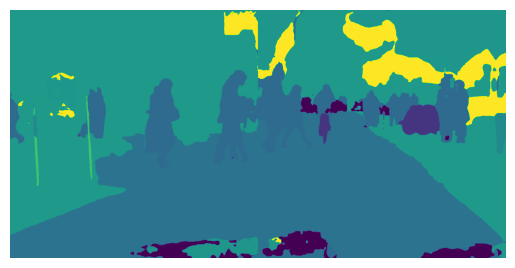

In [100]:
img =  Image.open(path).convert("L")
plt.imshow(img)
plt.axis("off")

In [108]:
transform = transforms.Compose([
    transforms.Resize((1024,1024),interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

resized_mask = transform(img)

In [109]:
resized_mask.unique()

tensor([ 16,  46,  70,  76,  84,  90, 108, 118, 119, 120, 153, 164, 210],
       dtype=torch.uint8)

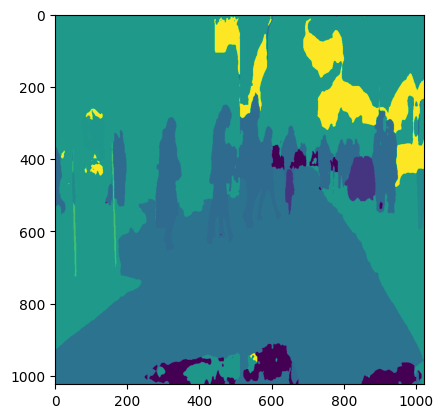

In [110]:
plt.imshow(resized_mask.squeeze())

In [66]:
l = list(map(open_image,paths[:3]))

In [67]:
a = torch.cat(l,dim=0)

In [68]:
a.shape

torch.Size([3, 1, 1024, 2048])